In [1]:
# ライブラリのインストール
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [2]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# ファイルのパスを指定
folder_name = "Data"
file_name = 'Ising_samp_data_L16.pkl'
file_path = os.path.join(folder_name, file_name)

# ファイルを読み込む
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

# 読み込んだデータを個々の変数に分割
spin_data, temp_data = loaded_data

In [6]:
# データの形を確認
spin_data.shape , len(temp_data)

(torch.Size([25000, 16, 16]), 25000)

In [7]:
print(spin_data[10000], temp_data[10000])

tensor([[-1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
         -1., -1.],
        [-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
          1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
          1., -1.],
        [-1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,
          1.,  1.],
        [-1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,
         -1.,  1.],
        [-1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
         -1.,  1.],
        [ 1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
          1.,  1.],
        [-1., -1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
          1.,  1.],
        [ 

In [4]:
# サンプルデータを訓練用とテスト用に分割(5:5)
spin_train, spin_test, temp_train, temp_test = train_test_split(spin_data, temp_data, test_size=0.5)

In [5]:
# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
temp_train = torch.tensor(temp_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
temp_test = torch.tensor(temp_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

C:\Users\soken\AppData\Local\Temp\ipykernel_20320\3927323180.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\soken\AppData\Local\Temp\ipykernel_20320\3927323180.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)


In [10]:
spin_train[1]

tensor([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [ 1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-

In [11]:
temp_train[1]

tensor([1.7500])

正解データはone-hot表現にする必要がある

In [6]:
# テンソルを新しいテンソルに変換する関数を定義
def to_one_hot(data, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(data), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(data):
        index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# temp_train,temp_testをone-hotベクトルに変換
one_hot_temp_train = to_one_hot(temp_train, num_classes=25)
one_hot_temp_test = to_one_hot(temp_test, num_classes=25)

In [13]:
one_hot_temp_train[0]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [14]:
temp_train[0]

tensor([0.2500])

In [8]:
# データセットの作成
train_dataset = TensorDataset(spin_train, one_hot_temp_train)
test_dataset = TensorDataset(spin_test, one_hot_temp_test)

In [16]:
train_dataset[0]

(tensor([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -

In [9]:
# 前処理を定義
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# データセットに前処理を適用
transformed_train_dataset = [(transform(tensor_sample), label) for tensor_sample, label in train_dataset]
transformed_test_dataset = [(transform(tensor_sample), label) for tensor_sample, label in test_dataset]

In [18]:
transformed_train_dataset[0]

(tensor([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -

In [10]:
# DataLoaderの設定（バッチサイズ12500）
train_loader = DataLoader(transformed_train_dataset, batch_size=125, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=125)

In [40]:
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([125, 16, 16]), torch.Size([125, 25]))

In [41]:
#class CNN(nn.Module):
#    def __init__(self, L, output_size):
#        super(CNN, self).__init__()
#        self.L = L
#        self.output_size = output_size
#        # 畳み込み層
#        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=4, padding=0)  # 周期パディング
#        self.periodic_padding = nn.ReflectionPad2d(1)  # 周期パディングを適用
#        # ReLU活性化関数
#        self.relu = nn.ReLU()
#        # 全結合層（バイアスなし）
#        self.fc = nn.Linear(5 * ((L - 1) // 4 + 1) ** 2, output_size)  # 出力サイズを output_size に調整
#        # ソフトマックス関数
#        self.softmax = nn.Softmax(dim=1)
#
#    def forward(self, x):
#        # 入力データのサイズ: (batch_size, 1, L, L)
#        x = self.periodic_padding(x)  # 周期パディングを適用
#        x = self.conv1(x)
#        # 畳み込み後のサイズ: (batch_size, 5, ((L - 1) // 4 + 1), ((L - 1) // 4 + 1))
#        x = self.relu(x)
#        x = x.view(x.size(0), -1)  # 平坦化
#        x = self.fc(x)
#        x = self.softmax(x)
#        return x

In [33]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 畳み込みの部分
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, stride=4, padding=1),
            nn.ReLU(inplace=True),
        )
        # 全結合の部分
        self.fc = nn.Sequential(
            nn.Linear(in_features=5*4*4, out_features=num_classes, bias=False),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [34]:
# モデルのインスタンス化
num_classes = 25  
model = CNN(num_classes)
#GPUに乗せる
model.to(device)
# モデルの概要表示
print(model)

CNN(
  (conv): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=25, bias=False)
    (1): Softmax(dim=1)
  )
)


In [35]:
# 損失関数と最適化アルゴリズムの設定
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差を採用
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)     # Adamという最適化手法を採用,L2正則化を設定

In [36]:
# 学習の実行
num_epochs = 5000
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      # outputの一番値が大きい成分
        targets = torch.argmax(targets, dim=1)  # targetの一番値が大きい成分
        running_acc += torch.mean(pred.eq(targets).float().cpu()) # predとtargetが同じになった数の平均
        optimizer.step()
    running_loss /= len(train_loader)   # 12500個の訓練データ全体での損失関数の平均
    running_acc /= len(train_loader)    # 12500個の訓練データ全体での正解率
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      # outputの一番値が大きい成分
        test_targets = torch.argmax(test_targets, dim=1)  # targetの一番値が大きい成分
        test_running_acc += torch.mean(test_pred.eq(test_targets).float().cpu()) # predとtargetの誤差が±0.5度である数の平均
    test_running_loss /= len(test_loader)   # 12500個の訓練データ全体での損失関数の平均
    test_running_acc /= len(test_loader)    # 12500個の訓練データ全体での正解率
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

RuntimeError: Given groups=1, weight of size [5, 5, 3, 3], expected input[1, 125, 16, 16] to have 5 channels, but got 125 channels instead

損失関数と正解率のグラフの作成

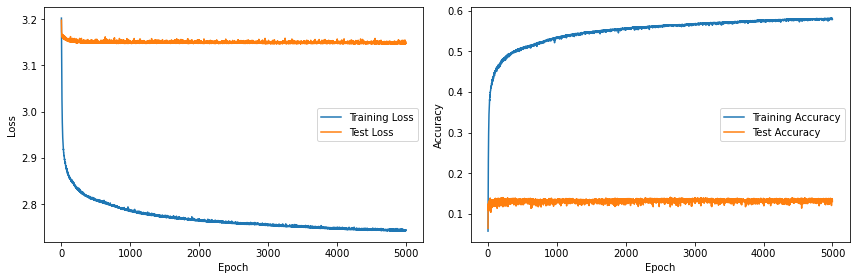

In [26]:
# グラフのプロット
plt.figure(figsize=(12, 4))

# 損失関数のグラフ
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 正解率のグラフ
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

実際に予測値と正解がどうなっているか見てみる

In [27]:
print(test_pred[:100])

tensor([22,  5, 16,  9,  9, 24,  5,  5,  5, 22, 21, 10, 18,  5, 20, 16, 24,  5,
        19,  5, 15, 16,  8, 18, 17, 10,  9, 15,  5,  5,  5,  9,  3,  5,  2, 22,
         5, 13,  0, 23,  0, 22, 13,  5, 18,  5,  9, 10, 15,  7, 14, 21, 15,  7,
         5, 12,  5, 18, 16,  2,  5,  7, 22, 21,  5, 10,  5,  7,  7,  7, 15, 17,
        13, 23, 20, 13, 16,  5,  5, 14, 13,  5,  9, 20, 18, 15, 20, 18,  5,  7,
         5, 13, 14,  2,  7, 15, 10,  8, 20,  7], device='cuda:0')


In [28]:
print(test_targets[:100])

tensor([19,  1, 18, 11,  4, 17,  0,  0,  6, 17, 21, 12, 22,  3, 14, 16, 10,  6,
        23,  4, 21, 24,  9, 23, 14, 10,  9, 21,  0,  3,  6,  9, 12,  2,  5, 11,
         7, 17,  4, 12,  6, 10, 24,  5, 24,  0, 12, 10, 10,  8, 11, 22, 17,  6,
         3, 19,  9, 23, 17, 21,  1,  6, 15, 21,  3, 10,  2,  6,  9,  7, 15, 15,
        14, 23, 24, 10, 15,  0,  5, 22, 13,  1, 10, 19, 18, 12, 22, 20,  6,  7,
        12, 14, 15,  2,  6, 19,  6,  8, 10,  8], device='cuda:0')


In [29]:
test_output.shape

torch.Size([125, 25])

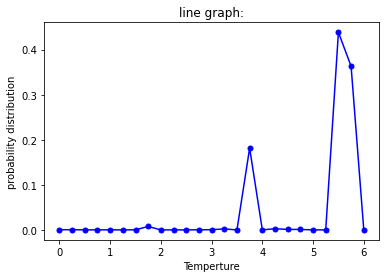

tensor(4.7500, device='cuda:0')


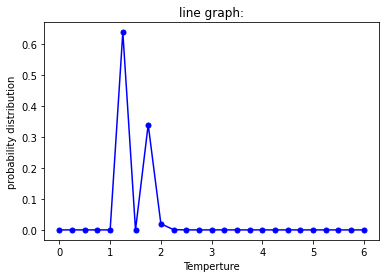

tensor(0.2500, device='cuda:0')


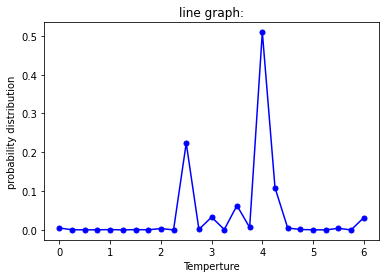

tensor(4.5000, device='cuda:0')


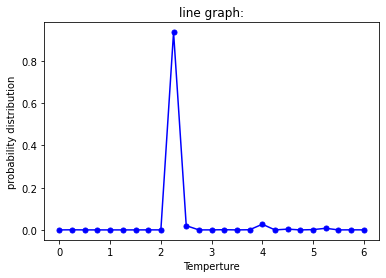

tensor(2.7500, device='cuda:0')


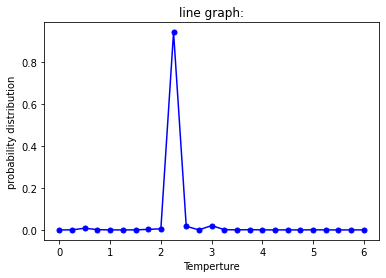

tensor(1., device='cuda:0')


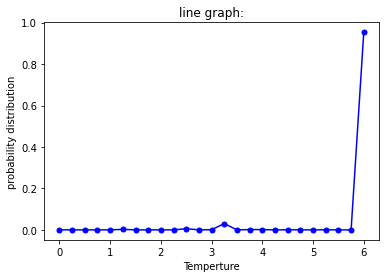

tensor(4.2500, device='cuda:0')


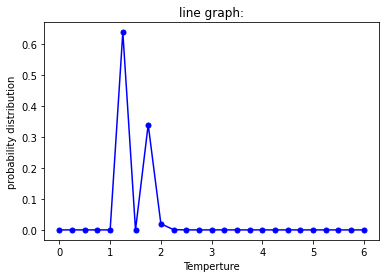

tensor(0., device='cuda:0')


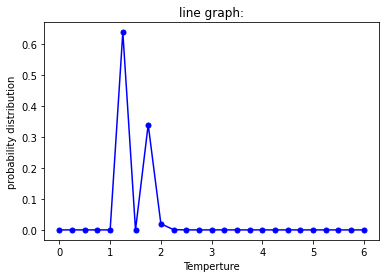

tensor(0., device='cuda:0')


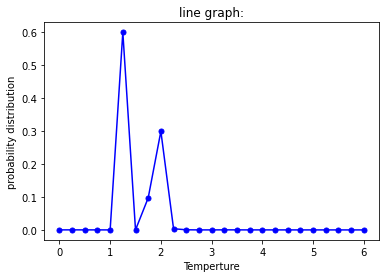

tensor(1.5000, device='cuda:0')


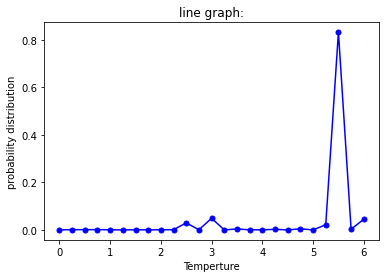

tensor(4.2500, device='cuda:0')


In [30]:
# データのx軸値
x = [i * 0.25 for i in range(25)]

for n in range(10):
    # テンソルをホストメモリにコピーしてNumpy配列に変換
    test_output_cpu = test_output[n].detach().cpu().numpy()

    # グラフを描画
    plt.plot(x, test_output_cpu, marker='o', linestyle='-', color='b', markersize=5)

    # グラフのタイトルと軸ラベルを設定
    plt.title('line graph:')
    plt.xlabel('Temperture')
    plt.ylabel('probability distribution')

    # グラフを表示
    plt.show()

    print(test_targets[n]*0.25)


モデルの保存

In [32]:
params = model.state_dict()
torch.save(params, "model_L=20.prm")